# Hand in: all details of your computations (the design of your neural network, the information table of the neural network. Find the best learning rate by the . )


# Problem1

## Train a deep MLP on the MNIST dataset 
(you can load it using `keras.datasets.mnist.load_data()`. See if you can get over 98% precision. 

Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). 

Try adding all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.

Let's load the dataset:

In [1]:
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
import tensorflow as tf
from tensorflow import keras
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

2025-02-28 19:24:39.945423: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-28 19:24:39.965735: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-28 19:24:40.364714: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-28 19:24:40.367828: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-28 19:24:43.528747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

Just like for the Fashion MNIST dataset, the MNIST training set contains 60,000 grayscale images, each 28x28 pixels

The validation set contains 5,000 images, and the test set contains 10,000 images

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255, just like we did for Fashion MNIST:

In [3]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

1. Let's plot an image using Matplotlib's `imshow()` function, with a `'binary'` color map:

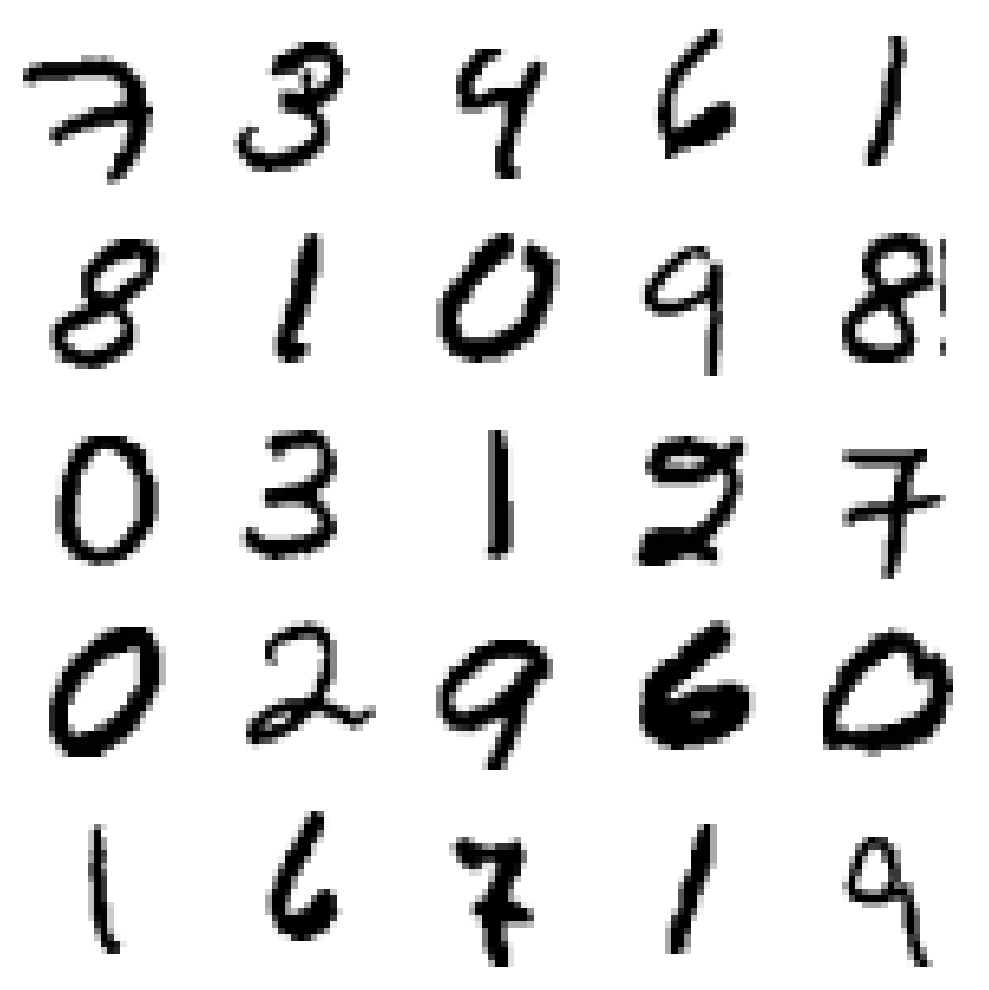

In [4]:
# If plotting the first 25th images:
num_images = 25  # The number of images plotted
grid_size = int(np.sqrt(num_images)) 

fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))  # Create a grid
for i, ax in enumerate(axes.flat): 
    ax.imshow(X_train[i], cmap="binary")  
    ax.axis('off')  

plt.tight_layout()  # Arrange the plot
plt.show()

In [5]:
print("Unique labels:", np.unique(y_train))

Unique labels: [0 1 2 3 4 5 6 7 8 9]


2. The labels are the class IDs (represented as uint8), from 0 to 9. Conveniently, the class IDs correspond to the digits represented in the images, so we don't need a `class_names` array:

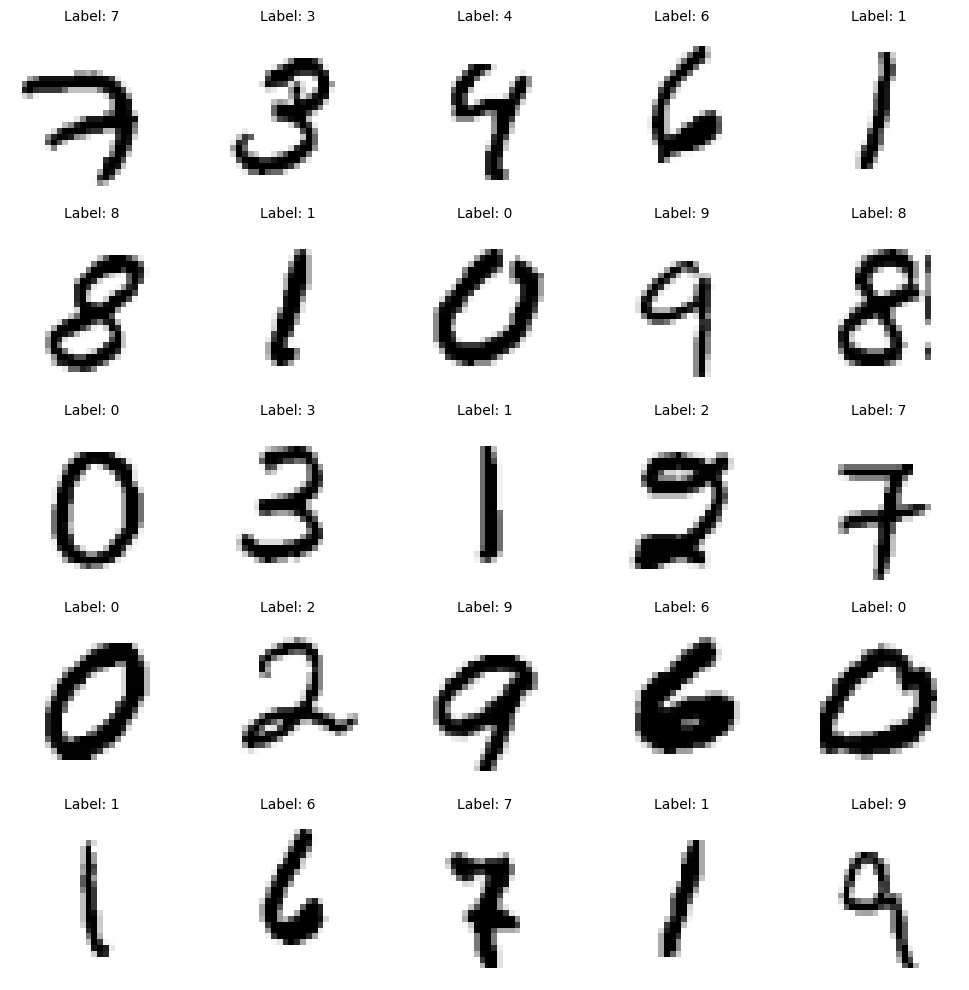

In [6]:
num_images = 25
grid_size = int(np.sqrt(num_images))

fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap="binary")  
    ax.set_title(f"Label: {y_train[i]}", fontsize=10)  # Display the corresponding label
    ax.axis('off') 

plt.tight_layout()
plt.show()

3. look at a sample of the images in the dataset:

In [7]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),  
    keras.layers.Dense(300, activation="relu"),  
    keras.layers.Dense(10, activation="softmax") 
])
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="sgd", 
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 10)                3010      
                                                                 
Total params: 238510 (931.68 KB)
Trainable params: 238510 (931.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


4. Build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration:
Now let's train the model for just 1 epoch:
We can now plot the loss as a function of the learning rate:
Find a good learning rate.

In [22]:
import tensorflow as tf
import numpy as np

class LearningRateTracker(tf.keras.callbacks.Callback):
    def __init__(self, initial_lr=1e-3, growth_rate=1.005):
        self.initial_lr = initial_lr
        self.growth_rate = growth_rate
        self.lrs = []
        self.losses = []

    def on_train_batch_end(self, batch, logs=None):
        # Calculate present learning rate
        current_lr = self.initial_lr * (self.growth_rate ** batch)
        self.lrs.append(current_lr)
        self.losses.append(logs["loss"]) 
        tf.keras.backend.set_value(self.model.optimizer.lr, current_lr)  # Update Learning Date

In [23]:
lr_tracker = LearningRateTracker()

history = model.fit(X_train, y_train, epochs=1, batch_size=32, 
                    validation_data=(X_valid, y_valid), 
                    callbacks=[lr_tracker])


1719/1719 [==============================] - 12s 7ms/step - loss: 1.8854 - accuracy: 0.3014 - val_loss: 2.3956 - val_accuracy: 0.1126


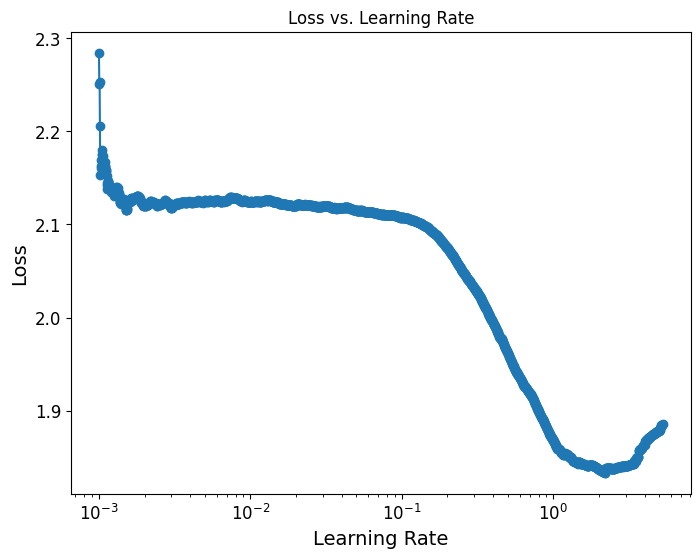

In [24]:
plt.figure(figsize=(8, 6))
plt.plot(lr_tracker.lrs, lr_tracker.losses, 'o-')
plt.xscale("log")  
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Loss vs. Learning Rate")
plt.show()


In [25]:
lrs = np.array(lr_tracker.lrs)
losses = np.array(lr_tracker.losses)

# Find the learning rate corresponding to minimum loss
min_loss_index = np.argmin(losses) 
best_lr = lrs[min_loss_index] 

#  Find the point where loss begins to rise
# Gradient of loss
gradients = np.diff(losses) 
increasing_indices = np.where(gradients > 0)[0] 

# Ensure inflection point occurs after minimum loss
turning_point_index = increasing_indices[increasing_indices > min_loss_index][0]
turning_point_lr = lrs[turning_point_index]

print(f"Learning rate corresponding to minimum loss: {best_lr:.6f}")
print(f"Learning rate corresponding to rising loss: {turning_point_lr:.6f}")


Learning rate corresponding to minimum loss: 2.177214
Learning rate corresponding to rising loss: 2.188100


Therefore, the best learning rate is between 1.015065 to 1.025241.

# Problem 2:

###   Train a deep neural network on the MRI slices dataset.  